In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymongo
import pyarrow as pa
import pyarrow.parquet as pq
from pymongoarrow.monkey import patch_all
patch_all()

from config import Config

client = pymongo.MongoClient(Config.MONGO_URI)
db = client[Config.MONGO_DB]

In [3]:
# aggregate + save
from loader import run
#
# set to True to rebuild training parquet files
need_to_rebuild_parquets = True
# set to 'force-refresh' to rebuild parquet files from DB
# set to 'auto' to use cached db results if they exist (TODO: implement auto cache check)
cache_mode = 'auto'
if need_to_rebuild_parquets:
    run(cache_mode=cache_mode)

[misp] Loading from cache
[misp] Processing phishing data
[misp] Running label transform
[misp] Running flatten transform
Saving to floor/after_flatten/phishing.parquet
[misp] Running tls transform
[misp] Running lexical transform
[misp] Running ip_entropy transform
[misp] Running countries_count transform
[misp] Running coords_stddev transform
[misp] Running dns_count transform
Saving to floor/phishing.parquet
[benign] Loading from cache
[benign] Processing benign data
[benign] Running label transform
[benign] Running flatten transform
Saving to floor/after_flatten/benign.parquet
[benign] Running tls transform
[benign] Running lexical transform
[benign] Running ip_entropy transform
[benign] Running countries_count transform
[benign] Running coords_stddev transform
[benign] Running dns_count transform
Saving to floor/benign.parquet


In [4]:
# load
phishing = pq.read_table('floor/phishing.parquet')
benign_u = pq.read_table('floor/benign.parquet')

from transformers.drop_nontrain import drop_nontrain
phishing = drop_nontrain(phishing)
benign_u = drop_nontrain(benign_u)

# realign schemas (parquet files save in nonsense orders)
phishing_order = phishing.schema.names
benign = benign_u.select(phishing_order)

data = pa.concat_tables([phishing, benign])
df = data.to_pandas()
from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

df

,label,domain_registration_date,domain_expiration_date,domain_last_changed_date,has_tls,tls_chain_len,tls_version_score,tls_cipher_score,root_cert_validity_len,root_cert_validity_remaining,...,countries_count,lat_stddev,lon_stddev,dns_A_count,dns_AAAA_count,dns_CNAME_count,dns_MX_count,dns_NS_count,dns_SOA_count,dns_TXT_count
0,misp:phishing,NaN,NaN,NaN,True,4.0,2.0,0.0,9066.0,4129.0,...,1,0.0,0.0,4,0,0,0,0,0,0
1,misp:phishing,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,...,1,0.0,0.0,1,0,0,0,0,0,0
2,misp:phishing,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0.0,0,0,0,0,0,0,0
3,misp:phishing,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,...,1,0.0,0.0,1,0,0,1,0,0,0
4,misp:phishing,NaN,NaN,NaN,True,3.0,3.0,1.0,3583.0,2124.0,...,1,0.0,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295348,benign:unknown,NaN,NaN,NaN,True,4.0,3.0,2.0,9132.0,2124.0,...,1,0.0,0.0,1,0,1,0,2,1,0
295349,benign:unknown,NaN,NaN,NaN,True,3.0,3.0,2.0,1349.0,570.0,...,1,0.0,0.0,2,0,1,0,0,0,0
295350,benign:unknown,NaN,NaN,NaN,True,3.0,3.0,2.0,1349.0,570.0,...,1,0.0,0.0,2,2,1,0,0,0,0
295351,benign:unknown,NaN,NaN,NaN,True,3.0,2.0,0.0,1349.0,570.0,...,1,0.0,0.0,1,0,0,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df['label'])
features = df.drop('label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

params = {
    "max_depth": 45,
    "eta": 0.2,
    "objective": "binary:logistic"
}
estimators = 20

model = XGBClassifier(
  **params, n_estimators=estimators
)
do_cross_val = True
if do_cross_val:
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
  results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

F1: 90.42% (0.28%)


In [6]:
_ = model.fit(X_train, y_train)

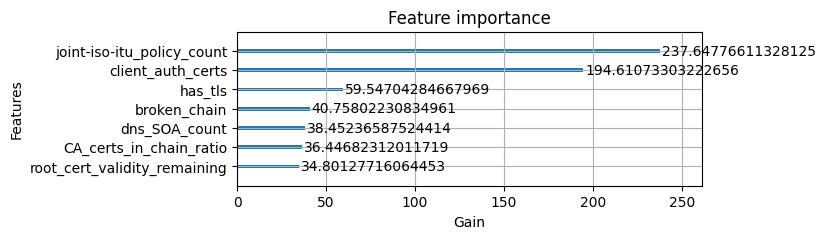

In [7]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
booster = model.get_booster()
fig, ax = pyplot.subplots(figsize=(6,2))
plot_importance(booster=booster, ax=ax, max_num_features=7, importance_type='gain')
ax.set_xlabel('Gain')
ax.set_ylabel('Features')
pyplot.show()

In [8]:
predicted = model.predict(X_test)

In [9]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

0.9057453999248968


In [10]:
# get gain score
score = model.get_booster().get_score(importance_type='gain')
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
sorted_score

[('joint-iso-itu_policy_count', 237.64776611328125),
 ('client_auth_certs', 194.61073303222656),
 ('has_tls', 59.54704284667969),
 ('broken_chain', 40.75802230834961),
 ('dns_SOA_count', 38.45236587524414),
 ('CA_certs_in_chain_ratio', 36.44682312011719),
 ('root_cert_validity_remaining', 34.80127716064453),
 ('domain_registration_date', 32.79766082763672),
 ('tls_cipher_score', 32.33226776123047),
 ('CA_certs_in_chain_count', 30.576406478881836),
 ('dns_TXT_count', 28.089731216430664),
 ('critical_extensions', 24.431825637817383),
 ('mean_certs_validity_len', 22.73640251159668),
 ('have_policies', 16.739933013916016),
 ('subdomain_length', 15.863418579101562),
 ('dns_CNAME_count', 15.59174633026123),
 ('tls_version_score', 15.1510009765625),
 ('dns_A_count', 14.109570503234863),
 ('subdomain_count', 12.903299331665039),
 ('tls_chain_len', 10.089150428771973),
 ('dns_NS_count', 9.795852661132812),
 ('leaf_cert_validity_len', 9.270288467407227),
 ('digit_count', 8.109434127807617),
 ('i

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted, digits=4))

[[76950   558]
 [ 1450  9648]]
              precision    recall  f1-score   support

           0     0.9815    0.9928    0.9871     77508
           1     0.9453    0.8693    0.9057     11098

    accuracy                         0.9773     88606
   macro avg     0.9634    0.9311    0.9464     88606
weighted avg     0.9770    0.9773    0.9769     88606



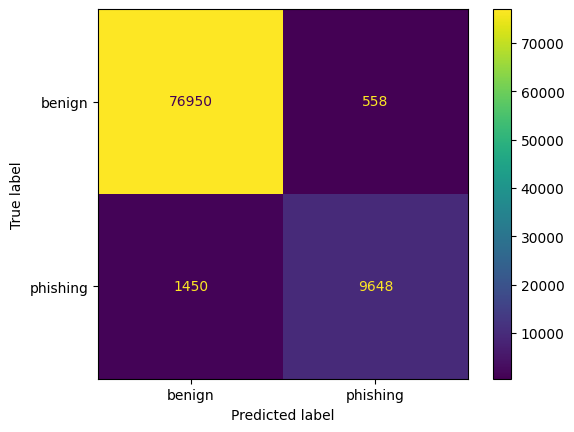

In [12]:
# confusion matrix display
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'phishing'])
disp.plot()